Referencias:
https://github.com/LuisAlejandroSalcedo/Procesamiento-de-Imagenes-con-Python-y-Scikit-Image/blob/master/README.md

https://www.kaggle.com/code/manifoldix/inceptionv3-for-retinopathy-gpu-hr/notebook

https://www.kaggle.com/code/zzdyyy/kaggle-tf1-impletation-of-o-o-solution

https://www.tensorflow.org/api_docs/python/tf/image


# Preparación del entorno


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**[IMPORTANTE]**Para poder ejecutar este notebook sin subir los archivos (ya que son muy pesados) se necesitan seguir los siguientes pasos:


*   Ir a https://drive.google.com/drive/folders/1uv1oO6UnuuLvkOzS61NSKu4uwDUKwJKV
*   Click derecho sobre la carpeta *retinografia*
*   Click en *Añadir acceso directo a Drive*
*   Selecciónar *Mi Unidad*
*   Dar al botón *Añadir acceso directo*



In [3]:
%matplotlib inline 

In [4]:
%mkdir /content/AAIA
%cd /content/AAIA

mkdir: cannot create directory ‘/content/AAIA’: File exists
/content/AAIA


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.io import imread
from glob import glob
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import time

In [6]:
#!unzip /content/drive/'My Drive'/retinografía/1216-test.zip
#!unzip /content/drive/'My Drive'/retinografía/4864-train.zip

In [7]:
%ls

1216-test/  4864-train/  retina_weights.best.hdf5


Creamos un índice para guardar las rutas a todas las imagines y su clasificación.

In [8]:
os.chdir('4864-train')

folders = ['0-noDR', '1-mild','2-moderate','3-severe', '4-proliferativeDR']

files = []

for folder in folders:
    for file in os.listdir(folder):
        files.append([file.split('.')[0],folder, folder.split('-')[0]])

pd.DataFrame(files, columns=['files','folder',  'target']).to_csv('files_and_targets.csv')

os.chdir('../1216-test')

files = []

for folder in folders:
    for file in os.listdir(folder):
        files.append([file.split('.')[0],folder, folder.split('-')[0]])

pd.DataFrame(files, columns=['files','folder', 'target']).to_csv('files_and_targets.csv')
os.chdir('../')

In [9]:
%ls 1216-test

0-noDR/  2-moderate/  4-proliferativeDR/
1-mild/  3-severe/    files_and_targets.csv


# Cargar Datos

In [10]:
#Traning data
base_image_dir = os.path.join('4864-train')

retina_df = pd.read_csv(os.path.join(base_image_dir,'files_and_targets.csv'))
retina_df['PatientId'] = retina_df['files'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df.apply(lambda x: os.path.join(base_image_dir,'{}'.format(x['folder']),
                                                         '{}.jpeg'.format(x['files'])), axis=1)
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['files'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['target'].map(lambda x: to_categorical(x, 1+int(retina_df['target'].max())))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

#Test data
base_image_dir = os.path.join('1216-test')

retina_df_test = pd.read_csv(os.path.join(base_image_dir,'files_and_targets.csv'))
retina_df_test['PatientId'] = retina_df_test['files'].map(lambda x: x.split('_')[0])
retina_df_test['path'] = retina_df_test.apply(lambda x: os.path.join(base_image_dir,'{}'.format(x['folder']),
                                                         '{}.jpeg'.format(x['files'])), axis=1)
retina_df_test['exists'] = retina_df_test['path'].map(os.path.exists)
print(retina_df_test['exists'].sum(), 'images found of', retina_df_test.shape[0], 'total')
retina_df_test['eye'] = retina_df_test['files'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df_test['level_cat'] = retina_df_test['target'].map(lambda x: to_categorical(x, 1+int(retina_df_test['target'].max())))

retina_df_test.dropna(inplace = True)
retina_df_test = retina_df_test[retina_df_test['exists']]
retina_df_test.sample(3)

4864 images found of 4864 total
1216 images found of 1216 total


,Unnamed: 0,files,folder,target,PatientId,path,exists,eye,level_cat
704,704,19897_left,2-moderate,2,19897,1216-test/2-moderate/19897_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
1186,1186,22379_right,4-proliferativeDR,4,22379,1216-test/4-proliferativeDR/22379_right.jpeg,True,0,"[0.0, 0.0, 0.0, 0.0, 1.0]"
947,947,20244_left,2-moderate,2,20244,1216-test/2-moderate/20244_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"


# Estandar

array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

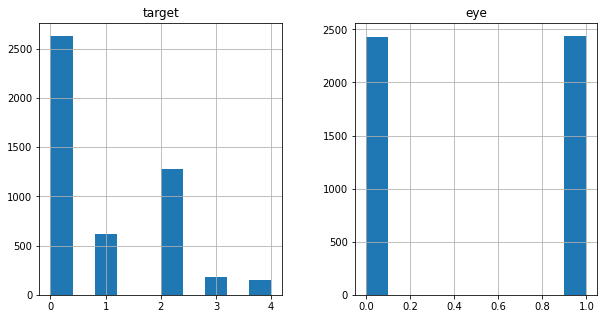

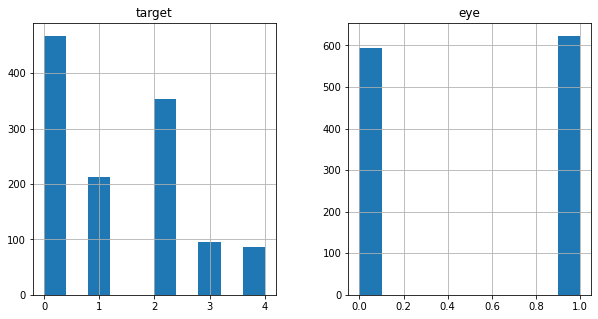

In [ ]:
retina_df[['target', 'eye']].hist(figsize = (10, 5))
retina_df_test[['target', 'eye']].hist(figsize = (10, 5))

## Definiciones y Preprocesado Datos

Como tenemos clases desbalanceadas utilizamos el siguiente proceso para balancearlas.
Utilizamos una pequeña fracción de los datos ya que con mayor cantidad el google colab nos corta la ejecución.

New Data Size: 500 Old Size: 4864
New Data Size: 500 Old Size: 1216


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

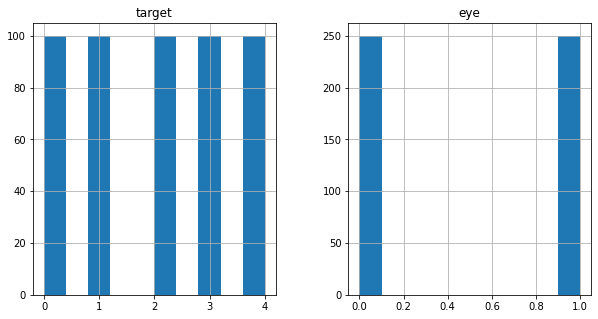

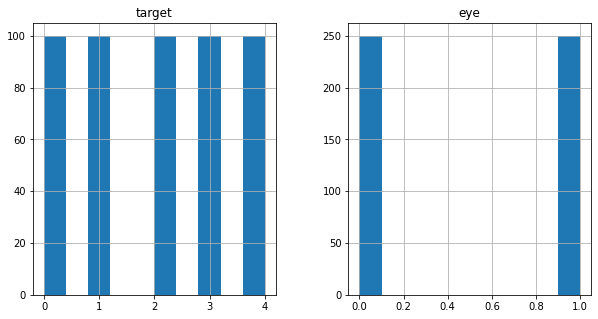

In [ ]:
train_df = retina_df.groupby(['target', 'eye']).apply(lambda x: x.sample(50, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', retina_df.shape[0])
train_df[['target', 'eye']].hist(figsize = (10, 5))

valid_df = retina_df_test.groupby(['target', 'eye']).apply(lambda x: x.sample(50, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', valid_df.shape[0], 'Old Size:', retina_df_test.shape[0])
valid_df[['target', 'eye']].hist(figsize = (10, 5))

In [ ]:
Funcioes auxiliares para trabajar con imagenes

In [ ]:
IMG_SIZE = (256, 256)
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.io.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)

    def batch_ops(X, y, rotation_range=0, crop_probability=0, min_crop_percent=0.6,
                  max_crop_percent=1.0, intermediate_size=(480, 480), out_size=(299, 299),
                  intermediate_trans='scale'):
        
        batch_size = tf.shape(X)[0]
        
        # Define identity transform
        identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
        
        with tf.name_scope('transformation'):
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random.uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.raw_ops.MatrixDiag(diagonal=[1, 1, tf.cos(angles), tf.sin(angles), 1, 0, 0, 0], num_rows=batch_size)]

            if crop_probability > 0:
                crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random.uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            
            if len(transforms)>0:
                # Compose all the transforms in the list into a single transform.
                M = transforms[0]
                for i in range(1, len(transforms)):
                    M = tf.linalg.matmul(transforms[i], M)
                X = tf.raw_ops.AffineImage(
                    images=X,
                    transforms=M,
                    interpolation='BILINEAR'
                ) # or 'NEAREST'
            
            if intermediate_trans=='scale':
                X = tf.image.resize(X, intermediate_size, method='bilinear')
            elif intermediate_trans=='crop':
                X = tf.image.resize_with_crop_or_pad(X, intermediate_size[0], intermediate_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
                        
            #Changes to the input images
            X = tf.image.resize(X, out_size, method='bilinear')
            
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [ ]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    tf.compat.v1.disable_eager_execution()
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        next_batch = tf.compat.v1.data.make_one_shot_iterator(idg(files_ds).repeat()).get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            sess = tf.compat.v1.keras.backend.get_session()
            yield sess.run(next_batch)

Inicialización de variables

In [ ]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

Comprobación del estado de las imagenes sacando una muestra de las mismas

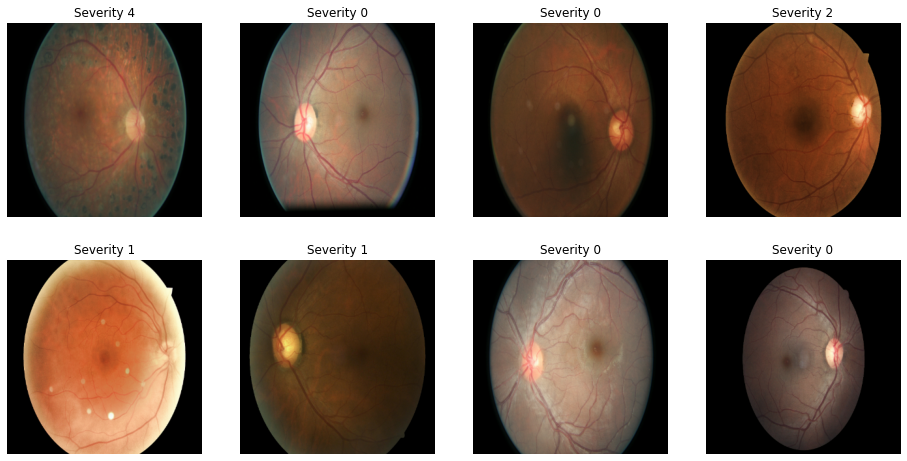

In [ ]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

## Modelo

Creación del modelo de aprendizaje a utilizar.

In [ ]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.layers[-1].output_shape[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 8, 8, 2048)   21802784    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 8, 8, 2048)  8192        ['inception_v3[0][0]']           
 ormalization)                                                                                    
                                                                                              

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

Entrenamiento

In [ ]:
tic = time.perf_counter()
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 10, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )
toc = time.perf_counter()
print(f"Training with full input in {toc - tic:0.4f} seconds")

<ipython-input-18-4549a7092921>:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  retina_model.fit_generator(train_gen,


Epoch 1/10
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 48.0000 - loss: 1.6837 - categorical_accuracy: 0.2542 - top_2_accuracy: 0.4917 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.83466, saving model to retina_weights.best.hdf5
10/10 [==============================] - 310s 30s/step - batch: 4.5000 - size: 48.0000 - loss: 1.6837 - categorical_accuracy: 0.2542 - top_2_accuracy: 0.4917 - val_loss: 1.8347 - val_categorical_accuracy: 0.2566 - val_top_2_accuracy: 0.4513 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 45.2000 - loss: 1.3186 - categorical_accuracy: 0.4358 - top_2_accuracy: 0.7013 
Epoch 2: val_loss improved from 1.83466 to 1.63833, saving model to retina_weights.best.hdf5
10/10 [==============================] - 343s 37s/step - batch: 4.5000 - size: 45.2000 - loss: 1.3180 - categorical_accuracy: 0.4358 - top_2_accuracy: 0.7013 - val_loss: 1.6383 - val_categorical_accuracy: 0.3146 - val_top_2_accuracy: 0.5333 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 45.2000 - loss: 1.2594 - categorical_accuracy: 0.5177 - top_2

Guardado del modelo ya entrenado

In [ ]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

## Tests

In [ ]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

<ipython-input-20-f0580e26fa13>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)),


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

<AxesSubplot:>

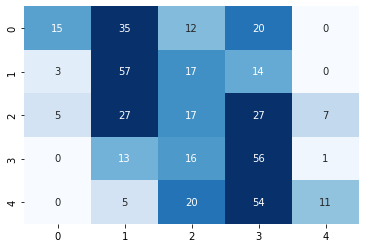

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

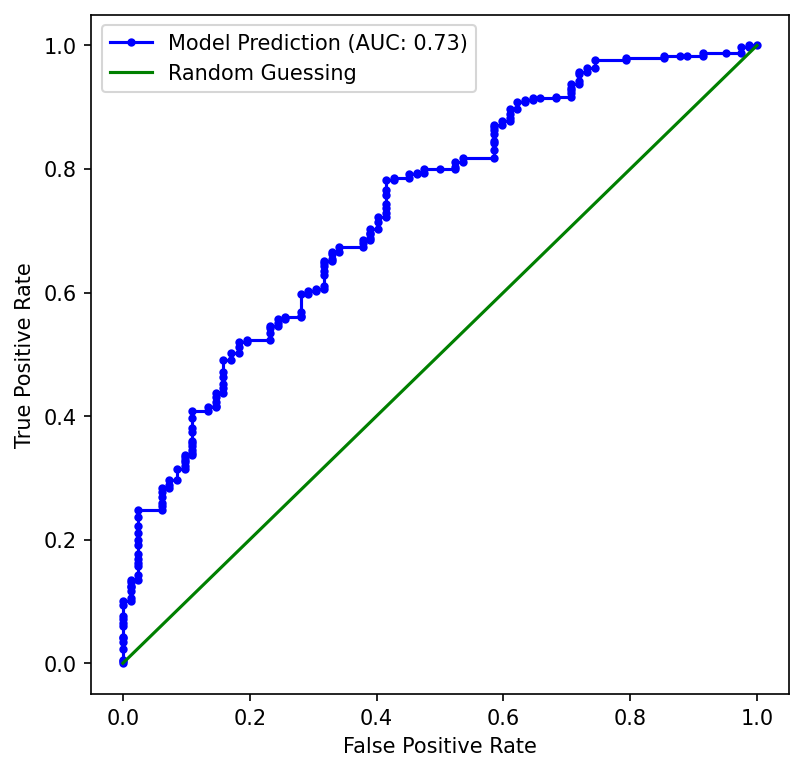

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

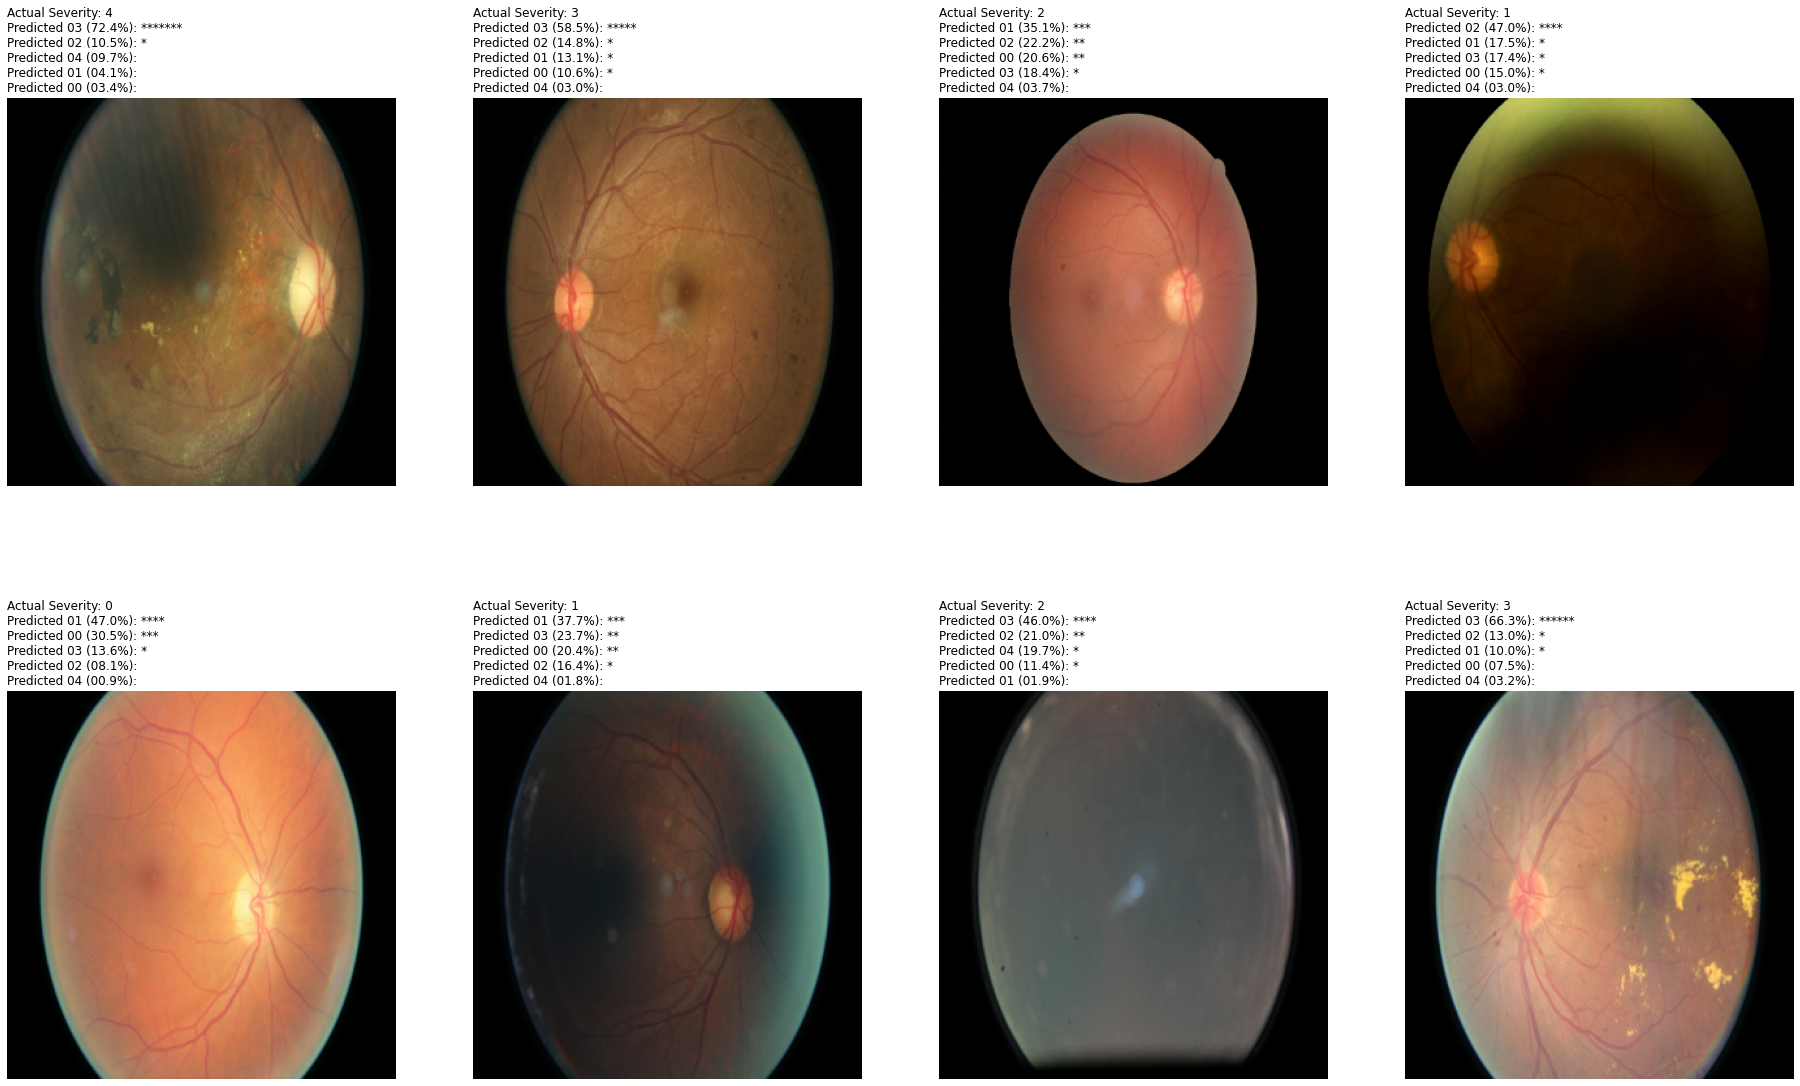

In [ ]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

Importar dependencias


# Alternativas

Aquí duplicamos el codigo estandar para mantener los resultados estandars mientras que jugamos con variaciones en el proceso.

array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

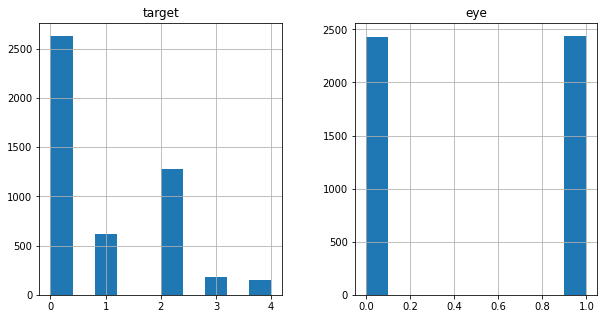

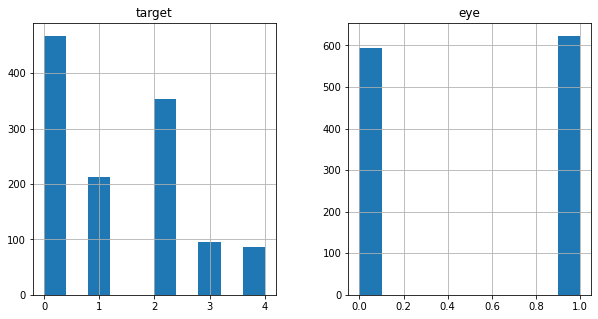

In [11]:
retina_df[['target', 'eye']].hist(figsize = (10, 5))
retina_df_test[['target', 'eye']].hist(figsize = (10, 5))

New Data Size: 600 Old Size: 4864
New Data Size: 300 Old Size: 1216


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

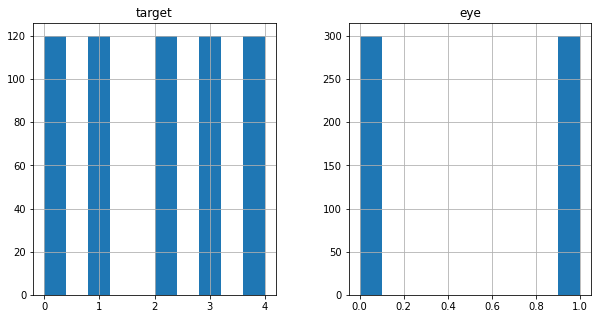

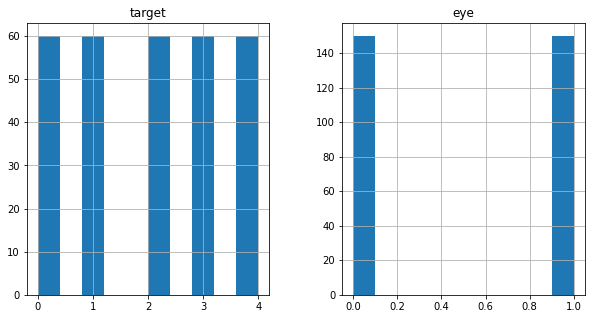

In [12]:
train_df = retina_df.groupby(['target', 'eye']).apply(lambda x: x.sample(60, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', retina_df.shape[0])
train_df[['target', 'eye']].hist(figsize = (10, 5))

valid_df = retina_df_test.groupby(['target', 'eye']).apply(lambda x: x.sample(30, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', valid_df.shape[0], 'Old Size:', retina_df_test.shape[0])
valid_df[['target', 'eye']].hist(figsize = (10, 5))

In [13]:
IMG_SIZE = (256, 256)
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.io.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)

    def batch_ops(X, y, rotation_range=0, crop_probability=0, min_crop_percent=0.6,
                  max_crop_percent=1.0, intermediate_size=(480, 480), out_size=(299, 299),
                  intermediate_trans='scale'):
        
        batch_size = tf.shape(X)[0]
        
        # Define identity transform
        identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
        
        with tf.name_scope('transformation'):
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random.uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.raw_ops.MatrixDiag(diagonal=[1, 1, tf.cos(angles), tf.sin(angles), 1, 0, 0, 0], num_rows=batch_size)]

            if crop_probability > 0:
                crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random.uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            
            if len(transforms)>0:
                # Compose all the transforms in the list into a single transform.
                M = transforms[0]
                for i in range(1, len(transforms)):
                    M = tf.linalg.matmul(transforms[i], M)
                X = tf.raw_ops.AffineImage(
                    images=X,
                    transforms=M,
                    interpolation='BILINEAR'
                ) # or 'NEAREST'
            
            if intermediate_trans=='scale':
                X = tf.image.resize(X, intermediate_size, method='bilinear')
            elif intermediate_trans=='crop':
                X = tf.image.resize_with_crop_or_pad(X, intermediate_size[0], intermediate_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
                        
            #Changes to the input images
            #Normalize size
            X = tf.image.resize(X, out_size, method='bilinear')
            #Standarize colors
            #X = tf.image.per_image_standardization(X)
            #More Contrast
            #X = tf.image.adjust_contrast(X, 2.)
            
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [14]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    tf.compat.v1.disable_eager_execution()
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        next_batch = tf.compat.v1.data.make_one_shot_iterator(idg(files_ds).repeat()).get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            sess = tf.compat.v1.keras.backend.get_session()
            yield sess.run(next_batch)

In [15]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

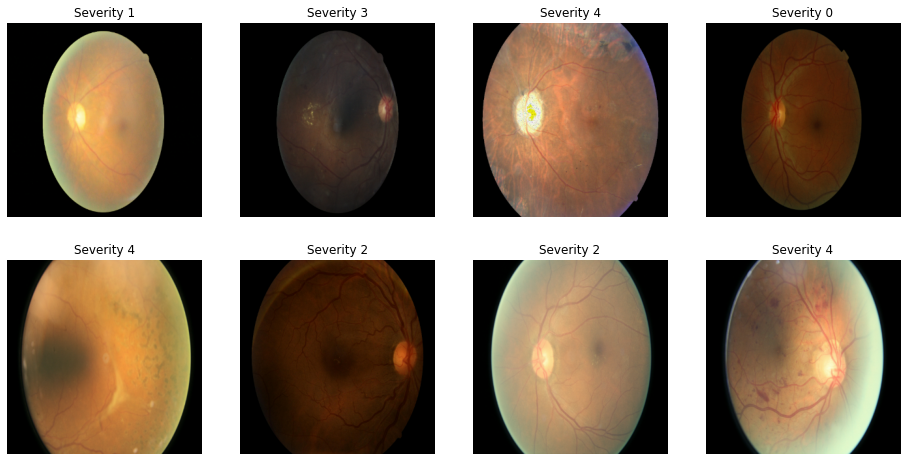

In [16]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [17]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.layers[-1].output_shape[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 8, 8, 2048)   21802784    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 8, 8, 2048)  8192        ['inception_v3[0][0]']           
 ormalization)                                                                                    
                                                                                              

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
tic = time.perf_counter()
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )
toc = time.perf_counter()
print(f"Training with full input in {toc - tic:0.4f} seconds")

<ipython-input-19-4ecff27bc88c>:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  retina_model.fit_generator(train_gen,


Epoch 1/25
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 48.0000 - loss: 1.6435 - categorical_accuracy: 0.2535 - top_2_accuracy: 0.4740

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.92352, saving model to retina_weights.best.hdf5
12/12 [==============================] - 60s 3s/step - batch: 5.5000 - size: 48.0000 - loss: 1.6435 - categorical_accuracy: 0.2535 - top_2_accuracy: 0.4740 - val_loss: 1.9235 - val_categorical_accuracy: 0.3095 - val_top_2_accuracy: 0.4127 - lr: 0.0010
Epoch 2/25
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 46.0000 - loss: 1.2877 - categorical_accuracy: 0.4620 - top_2_accuracy: 0.6938
Epoch 2: val_loss did not improve from 1.92352
12/12 [==============================] - 65s 6s/step - batch: 5.5000 - size: 46.0000 - loss: 1.2870 - categorical_accuracy: 0.4620 - top_2_accuracy: 0.6938 - val_loss: 2.2908 - val_categorical_accuracy: 0.3299 - val_top_2_accuracy: 0.3993 - lr: 0.0010
Epoch 3/25
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 46.0000 - loss: 1.2091 - categorical_accuracy: 0.5127 - top_2_accuracy: 0.7391
Epoch 3: val_loss did not improve

In [ ]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

In [ ]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

In [ ]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)